# Provenance

One aspect of data provenance is keeping track of the processing steps applied to data.

Next, we will learn how this can be done working with `xarray` objects.

In [1]:
import h5rdmtoolbox as h5tbx
import numpy as np

For the example, let's assume a 3D-velocity field with time, y- and x-dimension:

In [2]:
cv = h5tbx.conventions.from_zenodo('https://zenodo.org/record/8301535')

h5tbx.use(cv)

using("h5rdmtoolbox-tutorial-convention")

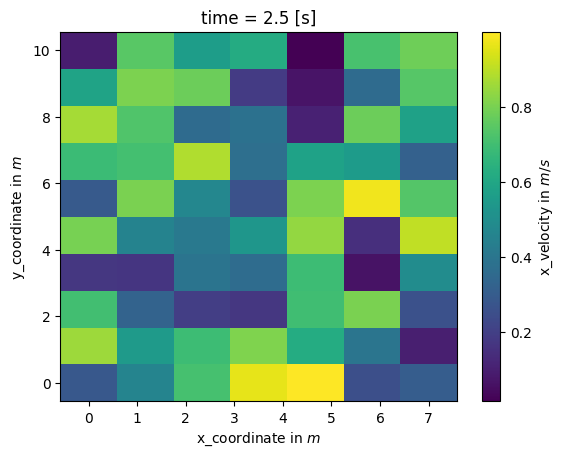

In [3]:
with h5tbx.File(data_type='experimental', contact=h5tbx.__author_orcid__) as h5:
    h5.create_dataset('time', data=np.linspace(0, 5, 5), standard_name='time', units='s', make_scale=True)
    h5.create_dataset('y', data=np.linspace(0, 10, 10), standard_name='y_coordinate', units='m', make_scale=True)
    h5.create_dataset('x', data=np.linspace(0, 7, 7), standard_name='x_coordinate', units='m', make_scale=True)
    h5.create_dataset('u', data=np.random.rand(5, 10, 7), standard_name='x_velocity', units='m/s', attach_scale=('time', 'y', 'x'))
    u = h5.u[:]

# plot t=2.5 s:
u.sel(time=2.5).plot()

In [4]:
from h5rdmtoolbox.conventions.standard_names import accessor

In [5]:
u_processed = u.snt[0:2,...].snt.arithmetic_mean_of(dim='time')

def get_dim_shape(da):
    return {d: len(da[d]) for d in da.dims}

def explain_history(da):
    for i, item in enumerate(da.attrs['PROVENANCE']['processing_history']):
        print(i, 'applied ', item['name'], ' on array with shape', item['parent']['dims_shape'])
        print('  -> ', item['name'])
    print('Current shape ', get_dim_shape(da))

explain_history(u_processed)

0 applied  __getitem__  on array with shape {'time': 5, 'y': 10, 'x': 7}
  ->  __getitem__
1 applied  arithmetic_mean_of  on array with shape {'time': 2, 'y': 10, 'x': 7}
  ->  arithmetic_mean_of
Current shape  {'y': 10, 'x': 7}


In [6]:
import json

u_processed.attrs['PROVENANCE']['HDF']

{'root': {'__h5rdmtoolbox_version__': '0.8rc2',
  'contact': array(['https://orcid.org/0000-0001-8729-0482'], dtype=object),
  'data_type': 'experimental',
  'standard_name_table': '10.5281/zenodo.8276716'},
 'group': {'__h5rdmtoolbox_version__': '0.8rc2',
  'contact': array(['https://orcid.org/0000-0001-8729-0482'], dtype=object),
  'data_type': 'experimental',
  'standard_name_table': '10.5281/zenodo.8276716'},
 'filename': 'C:\\Users\\da4323\\AppData\\Local\\h5rdmtoolbox\\h5rdmtoolbox\\tmp\\tmp_2\\tmp0.hdf'}

In [7]:
with h5tbx.use(None):
    with h5tbx.File() as h5:
        h5.create_dataset('u_processed', data=u_processed)

2023-09-05_16:03:18,786 ERROR    [core.py:768] Could not set attribute "PROVENANCE" with value "{'HDF': {'root': {'__h5rdmtoolbox_version__': '0.8rc2', 'contact': array(['https://orcid.org/0000-0001-8729-0482'], dtype=object), 'data_type': 'experimental', 'standard_name_table': '10.5281/zenodo.8276716'}, 'group': {'__h5rdmtoolbox_version__': '0.8rc2', 'contact': array(['https://orcid.org/0000-0001-8729-0482'], dtype=object), 'data_type': 'experimental', 'standard_name_table': '10.5281/zenodo.8276716'}, 'filename': 'C:\\Users\\da4323\\AppData\\Local\\h5rdmtoolbox\\h5rdmtoolbox\\tmp\\tmp_2\\tmp0.hdf'}, 'processing_history': [{'parent': {'dims_shape': {'time': 5, 'y': 10, 'x': 7}, 'coord_bounds': {'time': [{'dims': (), 'attrs': {'standard_name': 'time', 'units': 's'}, 'data': 0.0, 'coords': {'time': {'dims': (), 'attrs': {'standard_name': 'time', 'units': 's'}, 'data': 0.0}}, 'name': 'time'}, {'dims': (), 'attrs': {'standard_name': 'time', 'units': 's'}, 'data': 5.0, 'coords': {'time': {'

TypeError: Object of type ndarray is not JSON serializable

In [ ]:
---awd

Let's say we want to compute the time average of the above data, then we could do the following:

In [ ]:
u.mean(dim='time', keep_attrs=True)

This leaves us with two issues:
- the standard name of the new array is incorrect, it should be "arithmetic_mean_of_x_velocity"
- information about the original data is lost, e.g. what were the time bounds?

Provenance features must be implemented by the user. With standard names concept, we got such an example. Some of the transformations applicable to standard names can perform mathematical operations:

In [ ]:
from h5rdmtoolbox.conventions.standard_names import accessor

In [ ]:
from typing import Dict
class HDF5Provenance:

    def __init__(self, data: Dict):
        self._data = data

    @property
    def file(self):
        return self._data['HDF']

    def get_processing_history(self):
        return self._data['SNT_TRANSFORMATION_HISTORY']#_TRANSFORMATION_HISTORY']

In [ ]:
import xarray as xr

In [ ]:
u

In [ ]:
u_mean = u.snt.arithmetic_mean_of(dim=('time')).snt.arithmetic_mean_of(dim=('x'))
prov = u_mean.snt.get_provenance()

print(f'HDF source file: {HDF5Provenance(prov).file["filename"]}')
print('Transformation history:')

out = ''
for item in HDF5Provenance(prov).get_processing_history():
    for s in item['parent']['dims_shape'], ' --', item['name'], f'{tuple(item["bounds"].keys())}' ,' --> ':
        out += str(s)

out += str({d: len(u[d]) for d in u_mean.dims})
print(out)


In [ ]:
print(f'HDF source file: {HDF5Provenance(prov).file["filename"]}')
print('Transformation history:')
for item in HDF5Provenance(prov).get_processing_history():
    # print(item)
    print(item['name'])
    print(item['parent'])
    print(item['bounds'])
    print(item['len'])
    # dims = []
    # for dim_name, dim_data in v.items():
    #     _from = xr.DataArray.from_dict(v[dim_name]['bounds'][0])
    #     _to = xr.DataArray.from_dict(v[dim_name]['bounds'][1])
    #     _len = HDF5Provenance(prov).get_processing_history()['arithmetic_mean_of'][dim_name]['len']
    #     _from_str = f'{h5tbx.get_ureg().Quantity(_from.data[()], _from.units)}'
    #     _to_str = f'{h5tbx.get_ureg().Quantity(_to.data[()], _to.units)}'
    #     dims.append(f'{_len} data points of "{dim_name}" in bounds [{_from_str}, {_to_str}]')
    # print(f'  > "{k}" over\n     -', '\n     - '.join(dims))

In [ ]:
u_mean

In [ ]:
prov

In [ ]:
u_mean.coords

In [ ]:
da = xr.DataArray.from_dict(HDF5Provenance(prov).get_processing_history()['arithmetic_mean_of']['time'][0])
da